In [1]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.time import Time

import matplotlib.pyplot as plt


In [2]:
import sys, os
from ccdproc import ImageFileCollection

sys.path.append(os.path.expanduser('~/repos/ReipurthBallyProject/src'))
sys.path.append(os.path.expanduser('~/repos/runawaysearch/src'))
sys.path.append(os.path.expanduser('~/repos/ccd-reduction-and-photometry-guide/notebooks'))
#"C:\Users\Kevin\repos\ccd-reduction-and-photometry-guide"

In [19]:
subaru_fits_dir = r'G:\.shortcut-targets-by-id\1RzeL8kAByrV9UL-eKiEEtq-cAqlOUSnY\Subaru_for_Kevin'

#cols = ['MJD', 'OBJECT', 'DATA-TYP','DETECTOR','CRPIX1', 'CRPIX2', 'CRVAL1', 'CRVAL2', 'EXP1TIME', 'GAIN']
cols = ['MJD', 'OBJECT', 'DATA-TYP','DETECTOR','RA2000', 'DEC2000', 'CRVAL2', 'EXP1TIME', 'GAIN']
im_collection = ImageFileCollection(subaru_fits_dir,keywords=cols)

In [20]:
#im_collection.sort(['CRPIX1', 'CRPIX2', 'MJD'])
im_summary = im_collection.summary
im_summary['UTC'] = Time(im_summary['MJD'], scale='utc', format='mjd')
im_summary['UTC'].format = 'iso'


In [23]:
#im_summary.sort(['RA2000', 'DEC2000','MJD'])
im_summary.sort('file')

In [24]:
im_summary[im_summary['DATA-TYP']!='BIAS']


file,MJD,OBJECT,DATA-TYP,DETECTOR,RA2000,DEC2000,CRVAL2,EXP1TIME,GAIN,UTC
str17,float64,str4,str6,str8,str12,str12,float64,float64,float64,object
SUPA01564800.fits,57898.595399,M8,OBJECT,nausicaa,18:03:36.900,-24:23:11.95,-24.38665278,120.0,3.32,2017-05-25 14:17:22.474
SUPA01564801.fits,57898.595399,M8,OBJECT,kiki,18:03:36.900,-24:23:11.95,-24.38665278,120.0,3.3,2017-05-25 14:17:22.474
SUPA01564802.fits,57898.595399,M8,OBJECT,fio,18:03:36.900,-24:23:11.95,-24.38665278,120.0,2.96,2017-05-25 14:17:22.474
SUPA01564803.fits,57898.595399,M8,OBJECT,sophie,18:03:36.900,-24:23:11.95,-24.38665278,120.0,3.58,2017-05-25 14:17:22.474
SUPA01564804.fits,57898.595399,M8,OBJECT,sheeta,18:03:36.900,-24:23:11.95,-24.38665278,120.0,3.1,2017-05-25 14:17:22.474
SUPA01564805.fits,57898.595399,M8,OBJECT,satsuki,18:03:36.900,-24:23:11.95,-24.38665278,120.0,3.15,2017-05-25 14:17:22.474
SUPA01564806.fits,57898.595399,M8,OBJECT,chihiro,18:03:36.900,-24:23:11.95,-24.38665278,120.0,3.73,2017-05-25 14:17:22.474
SUPA01564807.fits,57898.595399,M8,OBJECT,clarisse,18:03:36.900,-24:23:11.95,-24.38665278,120.0,2.99,2017-05-25 14:17:22.474
SUPA01564808.fits,57898.595399,M8,OBJECT,ponyo,18:03:36.900,-24:23:11.95,-24.38665278,120.0,3.65,2017-05-25 14:17:22.474


In [9]:
import numpy as np
np.unique(im_summary['DETECTOR'])

chihiro
clarisse
fio
kiki
nausicaa
ponyo
san
satsuki
sheeta
sophie


In [25]:
bias_filter = {'DATA-TYP':'BIAS'}
im_bias = im_collection.filter(**bias_filter)

In [33]:
im_bias.summary.group_by('DETECTOR').groups.keys

DETECTOR
str8
chihiro
clarisse
fio
kiki
nausicaa
ponyo
san
satsuki
sheeta


In [38]:
im_bias_summary = im_bias.summary.group_by('DETECTOR')
for d in im_bias_summary.groups:
    d.name

AttributeError: 'Table' object has no attribute 'name'

In [8]:
im_collection.location,im_bias.location

('G:\\.shortcut-targets-by-id\\1RzeL8kAByrV9UL-eKiEEtq-cAqlOUSnY\\Subaru_for_Kevin',
 '')

In [9]:
from convenience_functions import show_image

In [13]:
for d in im_collection.data():
    data = d
    break
for b in im_bias.data():
    bias = b
    break

data.shape, bias.shape

((4273, 2272), (4273, 2272))

Text(0.5, 1.0, 'Difference')

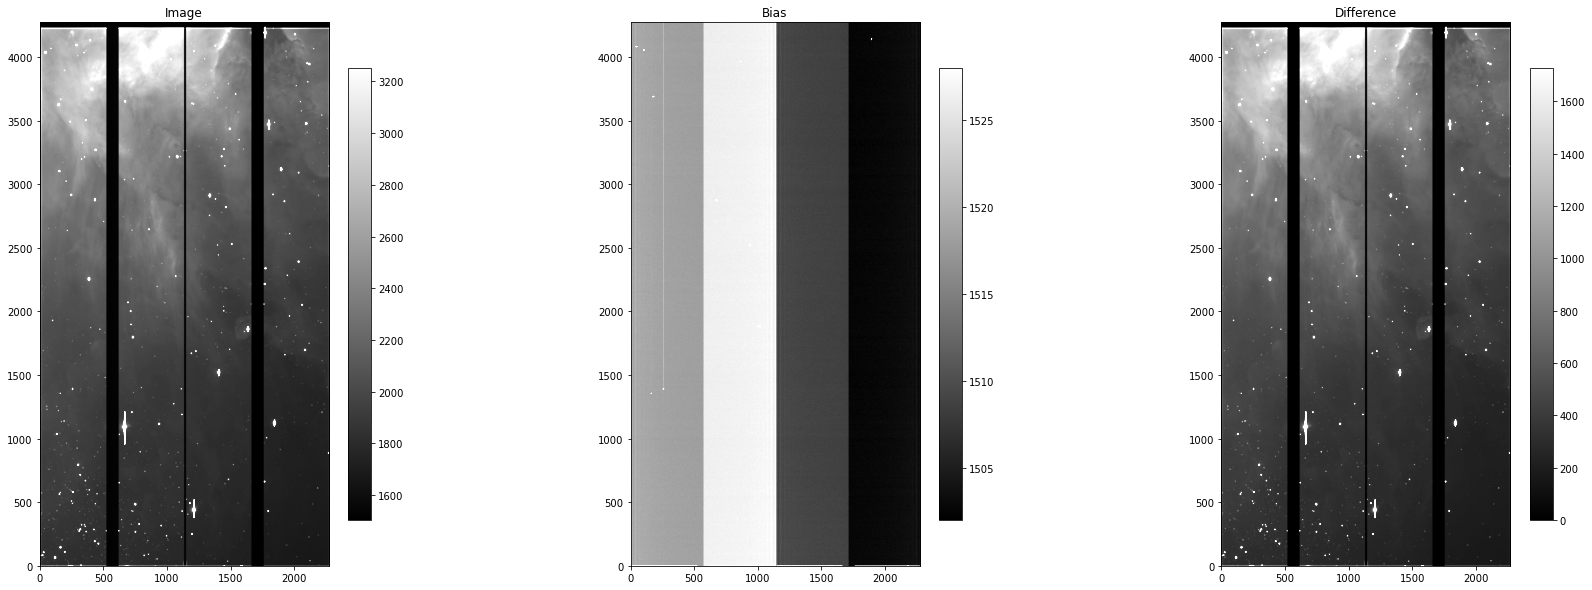

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
show_image(data, cmap='gray', ax=ax1, fig=fig)
ax1.set_title('Image')
show_image(bias, cmap='gray', ax=ax2, fig=fig)
ax2.set_title('Bias')
show_image(data.astype(float)-bias, cmap='gray', ax=ax3, fig=fig)
ax3.set_title('Difference')


In [17]:
#calibrated_biases = reduced_images.files_filtered(imagetyp='bias', include_path=True)

from astropy.nddata import CCDData
from astropy.stats import mad_std
import ccdproc as ccdp
import numpy as np

if os.path.exists('../data/Subaru/combined_bias.fits'):
    combined_bias = CCDData.read('../data/Subaru/combined_bias.fits')
else:
    combined_bias = ccdp.combine(im_collection.files_filtered(**bias_filter, include_path=True),
                                method='average',
                                sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std,
                                mem_limit=350e6
                                )

    combined_bias.meta['combined'] = True

    combined_bias.write('../data/Subaru/combined_bias.fits')

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


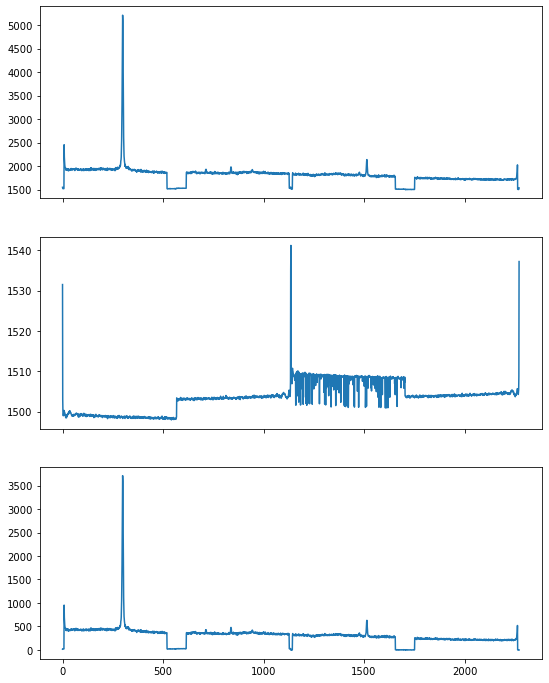

In [18]:
rownum=800
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9,12), sharex=True)
ax1.plot(data[rownum,:])
ax2.plot(combined_bias.data[rownum,:], alpha=1)
#ax2.plot(combined_bias.data[rownum,:], color='red', lw=2)
ax3.plot(data[rownum,:].astype(float)-combined_bias.data[rownum,:])

In [85]:
line = data[rownum,:].astype(float)-combined_bias.data[rownum,:]
overscan_cols = np.where(line < 1000)

Text(0.5, 1.0, '10 Random Bias v. Combined Bias')

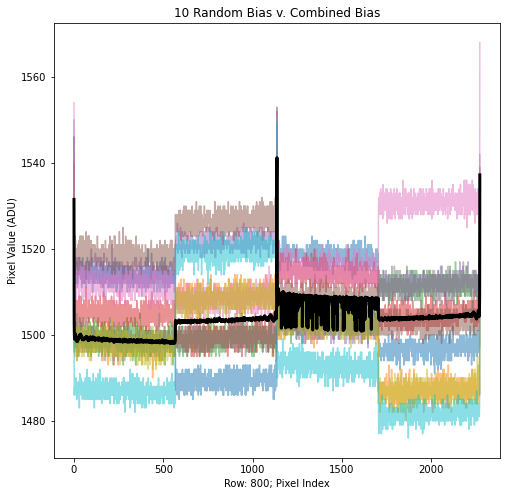

In [21]:
import random
import warnings
n_files = 10
bias_files = im_collection.files_filtered(**bias_filter, include_path=True)
fig, ax = plt.subplots(1, 1, figsize=(8,8), sharex=True)
for i in range(n_files):
    f = random.choice(bias_files)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        b = CCDData.read(f)
    ax.plot(b.data[rownum,:], alpha=0.5)

ax.plot(combined_bias.data[rownum,:], color='black', lw=3)
ax.set_ylabel('Pixel Value (ADU)')
ax.set_xlabel(f'Row: {rownum}; Pixel Index')
ax.set_title(f'{n_files} Random Bias v. Combined Bias')

Text(0.5, 1.0, 'Combined')

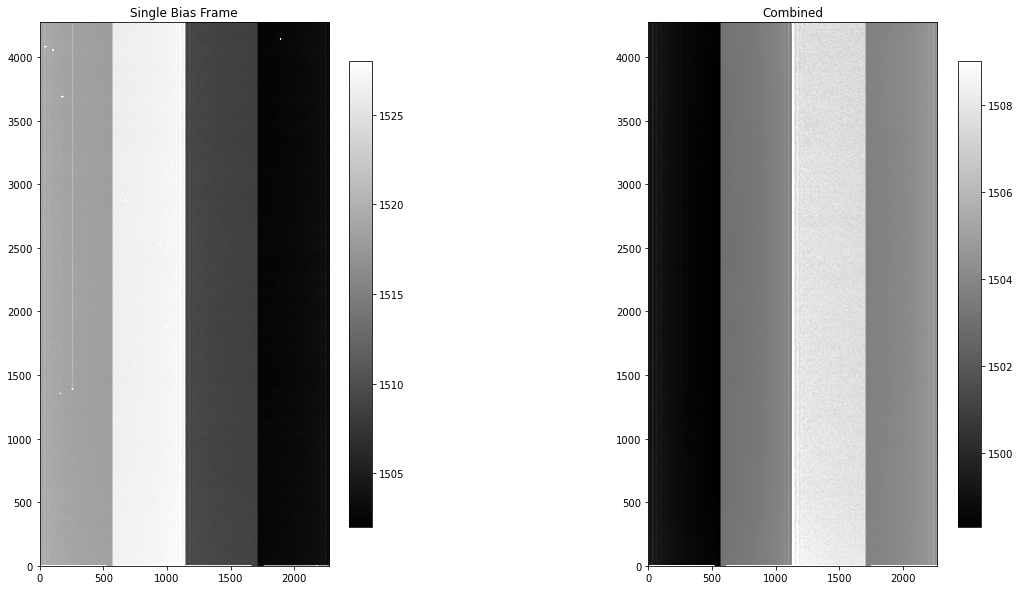

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
show_image(bias, cmap='gray', ax=ax1, fig=fig)

ax1.set_title('Single Bias Frame')
show_image(combined_bias.data, cmap='gray', ax=ax2, fig=fig)
ax2.set_title('Combined')

In [62]:
from astropy import units as u
import numpy as np
from astropy.nddata import CCDData
import ccdproc

In [23]:
# get just the image files
image_filter = {'DATA-TYP':'OBJECT', 'CRPIX1':-3130.0, 'CRPIX2': -37.0}
im_files = im_collection.files_filtered(include_path=True, **image_filter)

ccd = CCDData.read(im_files[0])


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
Set DATE-END to '2017-05-25T14:19:22.397' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2017-05-25T14:19:22.397' from MJD-END'.
  'degree' -> 'deg',
  'degree' -> 'deg'. [astropy.wcs.wcs]
  'degree' -> 'deg',
  'degree' -> 'deg'.


In [24]:
rownum = 300
line = ccd.data[rownum,:].astype(float)
overscan_cols = np.where(line < 2000)
overscan_cols

(array([   0,    1,    2,    3,    4,    5,    6,    7,  520,  521,  522,
         523,  524,  525,  526,  527,  528,  529,  530,  531,  532,  533,
         534,  535,  536,  537,  538,  539,  540,  541,  542,  543,  544,
         545,  546,  547,  548,  549,  550,  551,  552,  553,  554,  555,
         556,  557,  558,  559,  560,  561,  562,  563,  564,  565,  566,
         567,  568,  569,  570,  571,  572,  573,  574,  575,  576,  577,
         578,  579,  580,  581,  582,  583,  584,  585,  586,  587,  588,
         589,  590,  591,  592,  593,  594,  595,  596,  597,  598,  599,
         600,  601,  602,  603,  604,  605,  606,  607,  608,  609,  610,
         611,  612,  613,  614,  615, 1128, 1129, 1130, 1131, 1132, 1133,
        1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1656,
        1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665, 1666, 1667,
        1668, 1669, 1670, 1671, 1672, 1673, 1674, 1675, 1676, 1677, 1678,
        1679, 1680, 1681, 1682, 1683, 

In [25]:
os.path.basename(im_files[0])

'SUPA01564800.fits'

In [26]:
no_bias = ccdp.subtract_bias(ccd, combined_bias)
no_bias.write(os.path.join('../data/Subaru/no_bias', os.path.basename(im_files[0])), overwrite=True)

Text(0.5, 1.0, 'Bias Subtracted')

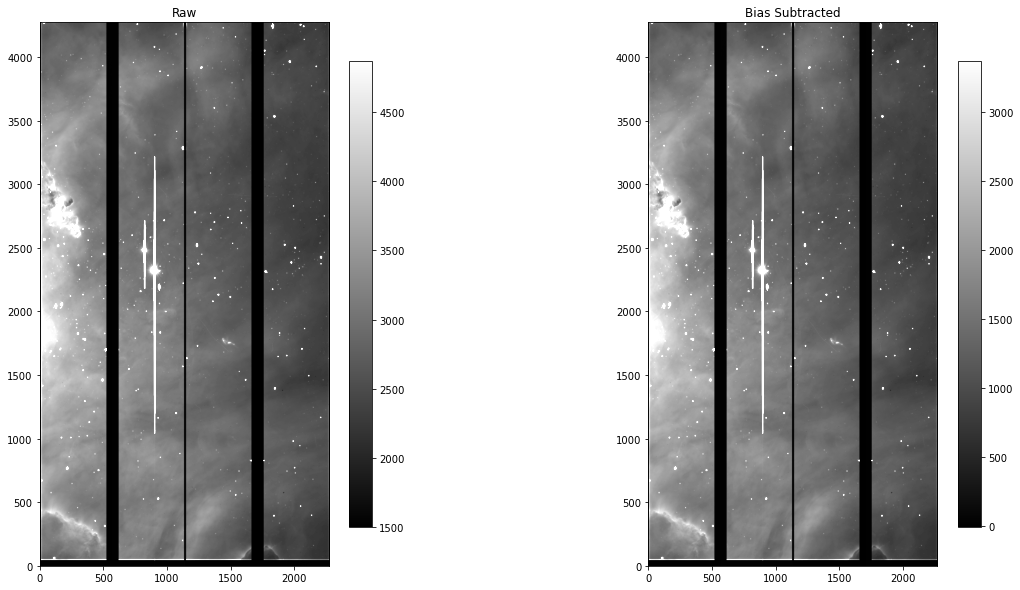

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
show_image(ccd.data, cmap='gray', ax=ax1, fig=fig)
ax1.set_title('Raw')

show_image(no_bias.data, cmap='gray', ax=ax2, fig=fig)
ax2.set_title('Bias Subtracted')

In [ ]:
#loop through all of the image files
image_filter = {'DATA-TYP':'OBJECT'}
im_files = im_collection.files_filtered(include_path=True, **image_filter)

for imf in im_files:
    ccd = CCDData.read(imf)
    no_bias = ccdp.subtract_bias(ccd, combined_bias)
    no_bias.write(os.path.join('../data/Subaru/no_bias', os.path.basename(imf)), overwrite=True)

In [28]:
ccd = CCDData.read(im_files[0])
colnum = rownum = 300
line = ccd.data[rownum,:].astype(float)
col = ccd.data[:,colnum].astype(float)
overscan_cols = np.where(line < 2000)
no_col_oscan = np.where(line >= 2000)[0]
no_row_oscan = np.where(col >= 2000)[0]

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
Set DATE-END to '2017-05-25T14:19:22.397' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2017-05-25T14:19:22.397' from MJD-END'.
  'degree' -> 'deg',
  'degree' -> 'deg'. [astropy.wcs.wcs]
  'degree' -> 'deg',
  'degree' -> 'deg'.


In [32]:
img_no_oscan = np.array([ccd.data[r, no_col_oscan] for r in no_row_oscan])
img_no_bias_oscan = np.array([no_bias.data[r, no_col_oscan] for r in no_row_oscan])

In [30]:
import matplotlib.colors as colors

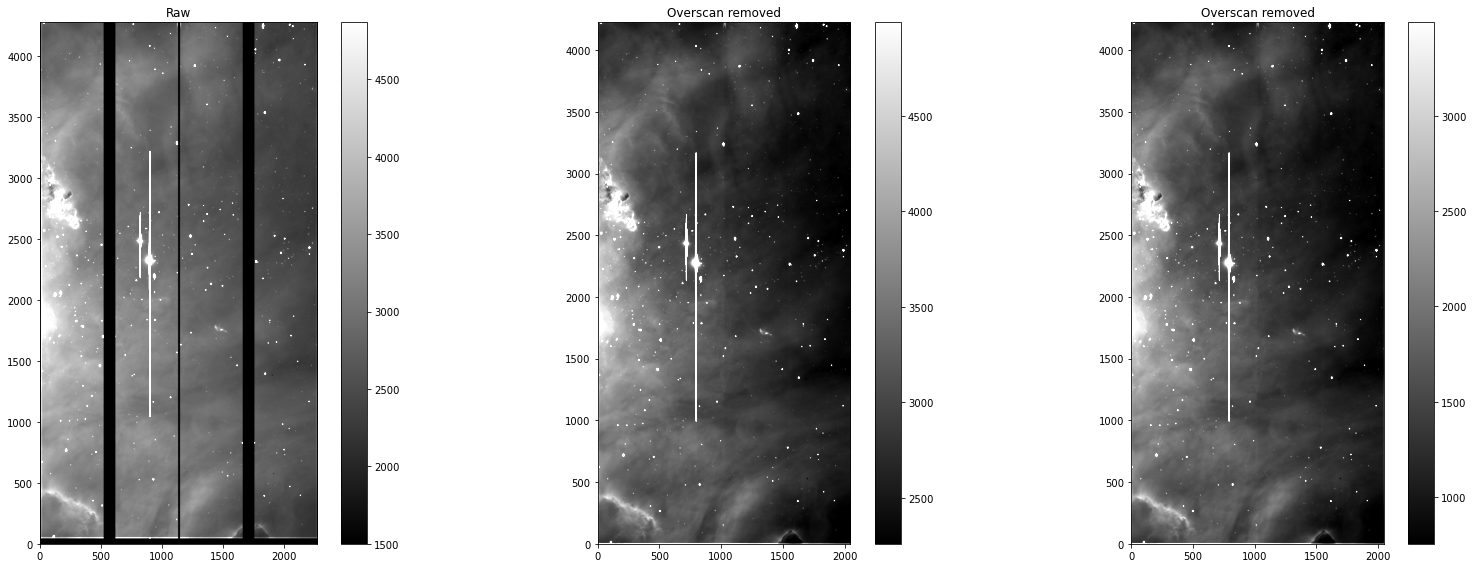

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))
show_image(ccd.data, cmap='gray', ax=ax1, fig=fig,log=False)
ax1.set_title('Raw')

show_image(img_no_oscan, cmap='gray', ax=ax2, fig=fig, log=False)
ax2.set_title('Overscan removed')

show_image(img_no_bias_oscan, cmap='gray', ax=ax3, fig=fig, log=False)
ax3.set_title('Overscan and Bias removed')

plt.tight_layout()

In [34]:
im_files

['G:\\.shortcut-targets-by-id\\1RzeL8kAByrV9UL-eKiEEtq-cAqlOUSnY\\Subaru_for_Kevin\\SUPA01564800.fits',
 'G:\\.shortcut-targets-by-id\\1RzeL8kAByrV9UL-eKiEEtq-cAqlOUSnY\\Subaru_for_Kevin\\SUPA01564810.fits',
 'G:\\.shortcut-targets-by-id\\1RzeL8kAByrV9UL-eKiEEtq-cAqlOUSnY\\Subaru_for_Kevin\\SUPA01564820.fits',
 'G:\\.shortcut-targets-by-id\\1RzeL8kAByrV9UL-eKiEEtq-cAqlOUSnY\\Subaru_for_Kevin\\SUPA01564830.fits',
 'G:\\.shortcut-targets-by-id\\1RzeL8kAByrV9UL-eKiEEtq-cAqlOUSnY\\Subaru_for_Kevin\\SUPA01564840.fits']

In [135]:
ccd.data.shape, img_no_oscan.shape

((4273, 2272), (4226, 2048))

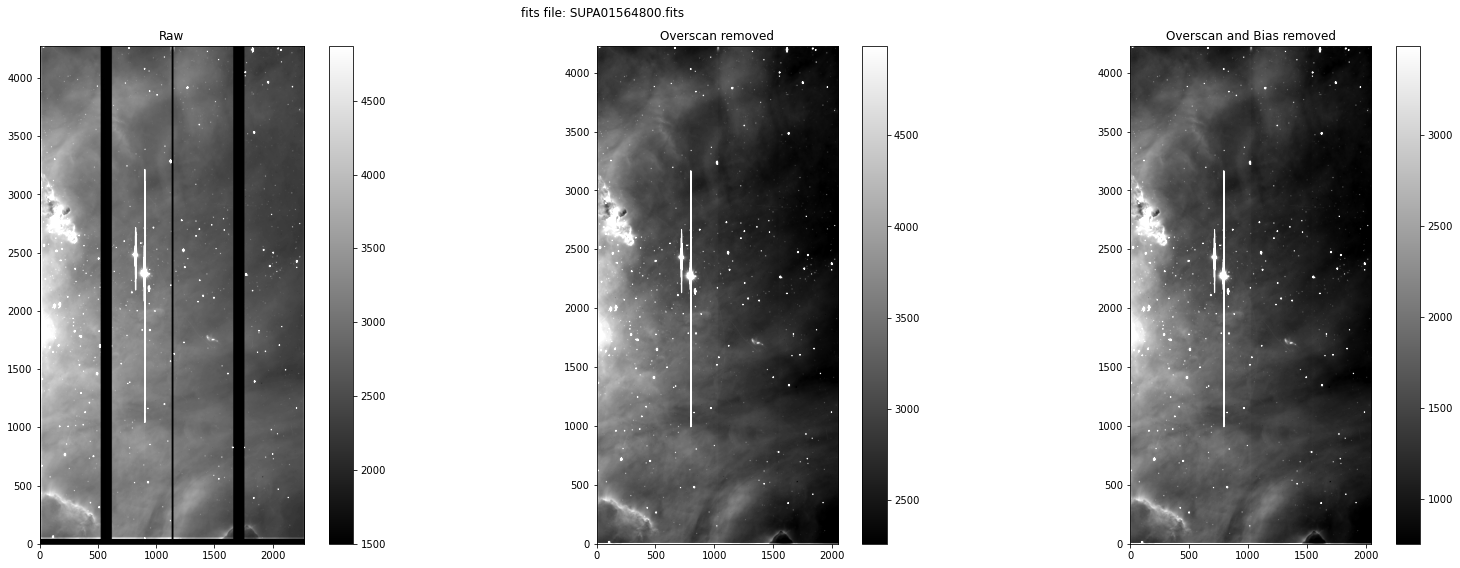

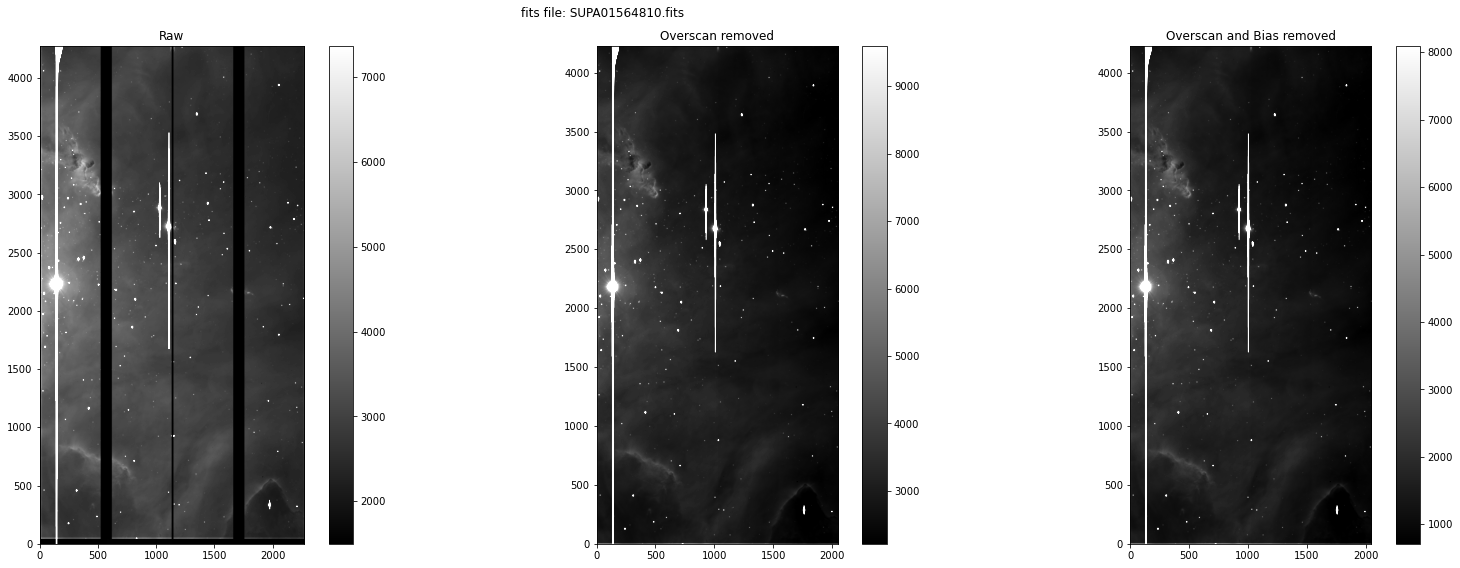

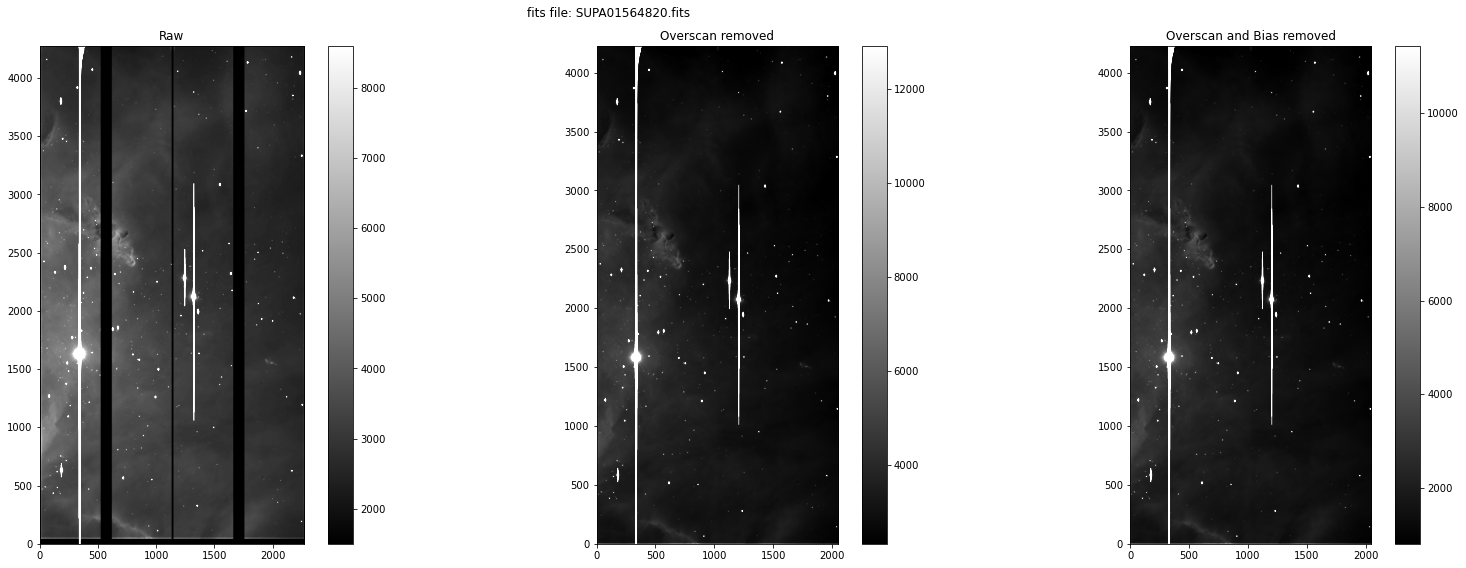

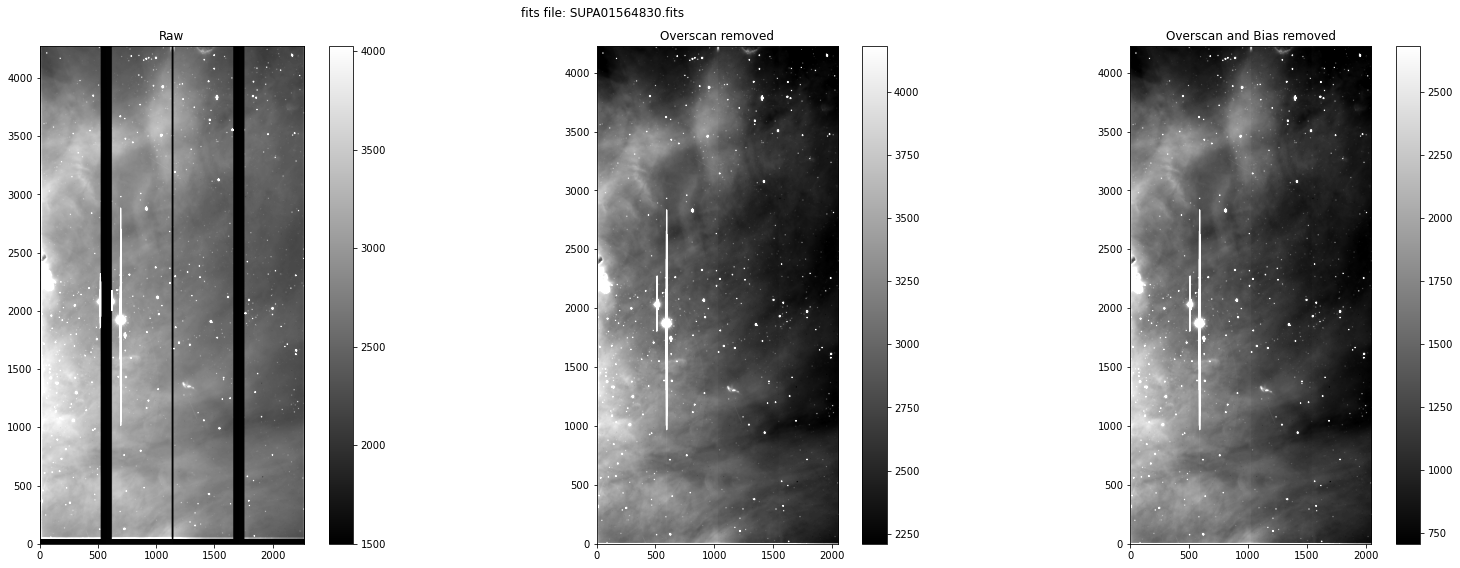

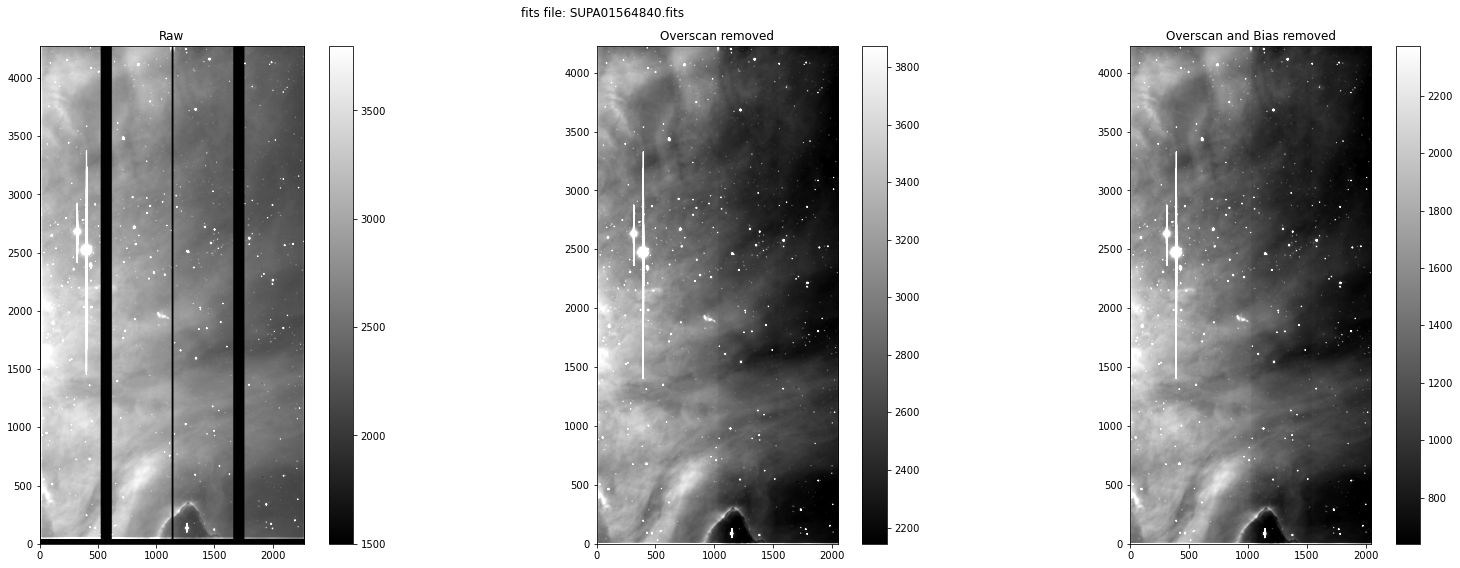

In [41]:
import warnings
for f in im_files:
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        ccd = CCDData.read(f)
    no_bias = ccdp.subtract_bias(ccd, combined_bias)
    img_no_oscan = np.array([ccd.data[r, no_col_oscan] for r in no_row_oscan])
    img_no_bias_oscan = np.array([no_bias.data[r, no_col_oscan] for r in no_row_oscan])

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))
    show_image(ccd.data, cmap='gray', ax=ax1, fig=fig,log=False)
    ax1.set_title('Raw')

    show_image(img_no_oscan, cmap='gray', ax=ax2, fig=fig, log=False)
    ax2.set_title('Overscan removed')

    show_image(img_no_bias_oscan, cmap='gray', ax=ax3, fig=fig, log=False)
    ax3.set_title('Overscan and Bias removed')
    
    plt.suptitle(f'fits file: {os.path.basename(f)}')
    plt.tight_layout()

In [44]:
ccd.header.get('PC1_1')

In [45]:
np.random.choice(len(bias_files), n_files).astype(int)

array([84, 72, 30, 63, 43, 73, 32, 36, 85, 39])

In [3]:
hdrs = {}
wcss = {}
for f in subaru_fits_list:
    fits_path = os.path.join(subaru_fits_dir, f)
    hdrs[f] = fits.getheader(fits_path)
    wcss[f] = WCS(hdrs[f])

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set DATE-END to '2017-05-25T14:19:22.397' from MJD-END'. [astropy.wcs.wcs]
  'degree' -> 'deg',
  'degree' -> 'deg'. [astropy.wcs.wcs]
Set DATE-END to '2017-05-25T14:21:51.437' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2017-05-25T14:24:21.427' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2017-05-25T14:26:51.418' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2017-05-25T14:29:21.408' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2017-05-25T16:29:34.512' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2017-05-25T16:30:03.370' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2017-05-25T16:30:31.968' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2017-05-25T16:31:00.134' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2017-05-25T16:31:28.128' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2017-05-25T16:31:56.381' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2017-05-25T16:32:24.288' from 

In [82]:
im_summary.sort('file')
im_collection.filter(**{'CRPIX1':-3130, 'CRPIX2':-37}).summary[['MJD','OBJECT','DATA-TYP',
    'CRPIX1', 'CRPIX2', 'CRVAL1', 'CRVAL2']]

MJD,OBJECT,DATA-TYP,CRPIX1,CRPIX2,CRVAL1,CRVAL2
float64,str4,str6,float64,float64,float64,float64
57898.595399,M8,OBJECT,-3130.0,-37.0,270.90375,-24.38665278
57898.597125,M8,OBJECT,-3130.0,-37.0,270.91595833,-24.40886944
57898.598861,M8,OBJECT,-3130.0,-37.0,270.92815833,-24.37553611
57898.600603,M8,OBJECT,-3130.0,-37.0,270.89155833,-24.36442222
57898.602335,M8,OBJECT,-3130.0,-37.0,270.87937083,-24.39777222
57898.687205,BIAS,BIAS,-3130.0,-37.0,335.22845417,19.743375
57898.687539,BIAS,BIAS,-3130.0,-37.0,335.34497083,19.74329722
57898.68787,BIAS,BIAS,-3130.0,-37.0,335.46858333,19.74321667
57898.688196,BIAS,BIAS,-3130.0,-37.0,335.58593333,19.74313889


In [63]:
im_bias.summary.group_by(['CRPIX1', 'CRPIX2'])

file,MJD,OBJECT,DATA-TYP,CRPIX1,CRPIX2,CRVAL1,CRVAL2,EXP1TIME,GAIN,UTC
str95,float64,str4,str4,float64,float64,float64,float64,float64,float64,float64
G:\.shortcut-targets-by-id\1RzeL8kAByrV9UL-eKiEEtq-cAqlOUSnY\Subaru_for_Kevin\SUPA01565483.fits,57898.687205,BIAS,BIAS,-3153.0,4167.0,335.22845417,19.743375,0.0,3.58,--
G:\.shortcut-targets-by-id\1RzeL8kAByrV9UL-eKiEEtq-cAqlOUSnY\Subaru_for_Kevin\SUPA01565493.fits,57898.687539,BIAS,BIAS,-3153.0,4167.0,335.34497083,19.74329722,0.0,3.58,--
G:\.shortcut-targets-by-id\1RzeL8kAByrV9UL-eKiEEtq-cAqlOUSnY\Subaru_for_Kevin\SUPA01565503.fits,57898.68787,BIAS,BIAS,-3153.0,4167.0,335.46858333,19.74321667,0.0,3.58,--
G:\.shortcut-targets-by-id\1RzeL8kAByrV9UL-eKiEEtq-cAqlOUSnY\Subaru_for_Kevin\SUPA01565513.fits,57898.688196,BIAS,BIAS,-3153.0,4167.0,335.58593333,19.74313889,0.0,3.58,--
G:\.shortcut-targets-by-id\1RzeL8kAByrV9UL-eKiEEtq-cAqlOUSnY\Subaru_for_Kevin\SUPA01565523.fits,57898.68852,BIAS,BIAS,-3153.0,4167.0,335.70328333,19.74306389,0.0,3.58,--
G:\.shortcut-targets-by-id\1RzeL8kAByrV9UL-eKiEEtq-cAqlOUSnY\Subaru_for_Kevin\SUPA01565533.fits,57898.688847,BIAS,BIAS,-3153.0,4167.0,335.82063333,19.74298889,0.0,3.58,--
G:\.shortcut-targets-by-id\1RzeL8kAByrV9UL-eKiEEtq-cAqlOUSnY\Subaru_for_Kevin\SUPA01565543.fits,57898.68917,BIAS,BIAS,-3153.0,4167.0,335.93756667,19.74291389,0.0,3.58,--
G:\.shortcut-targets-by-id\1RzeL8kAByrV9UL-eKiEEtq-cAqlOUSnY\Subaru_for_Kevin\SUPA01565553.fits,57898.689497,BIAS,BIAS,-3153.0,4167.0,336.05575417,19.74283611,0.0,3.58,--
G:\.shortcut-targets-by-id\1RzeL8kAByrV9UL-eKiEEtq-cAqlOUSnY\Subaru_for_Kevin\SUPA01565563.fits,57898.689831,BIAS,BIAS,-3153.0,4167.0,336.17602917,19.74276111,0.0,3.58,--


In [68]:
len(im_bias.files)

90

In [71]:
from utils import obs_dirs
obs_dirs('./data', 'M8', None)

{'raw_image': './data\\M8\\raw_image',
 'raw_bias': './data\\M8\\raw_bias',
 'xmap_tables': './data\\M8\\xmap_tables',
 'false_image': './data\\M8\\false_image',
 'registered_image': './data\\M8\\registered_image',
 'no_bias': './data\\M8\\no_bias',
 'calibration_info': './data\\M8\\calibration_info'}

In [72]:
hdu = fits.open(r'G:\.shortcut-targets-by-id\1RzeL8kAByrV9UL-eKiEEtq-cAqlOUSnY\Subaru_for_Kevin\SUPA01564803.fits')[0]

In [73]:
wcs = WCS(hdu)
wcs

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
Set DATE-END to '2017-05-25T14:19:22.397' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2017-05-25T14:19:22.397' from MJD-END'.
  'degree' -> 'deg',
  'degree' -> 'deg'. [astropy.wcs.wcs]
  'degree' -> 'deg',
  'degree' -> 'deg'.


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 270.90375  -24.38665278  
CRPIX : -3153.0  4167.0  
CD1_1 CD1_2  : -5.611e-05  0.0  
CD2_1 CD2_2  : 0.0  5.611e-05  
NAXIS : 2272  4273

In [74]:
wcs.to_header()

WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =              -3153.0 / Pixel coordinate of reference point            
CRPIX2  =               4167.0 / Pixel coordinate of reference point            
PC1_1   =           -5.611E-05 / Coordinate transformation matrix element       
PC2_2   =            5.611E-05 / Coordinate transformation matrix element       
CDELT1  =                  1.0 / [deg] Coordinate increment at reference point  
CDELT2  =                  1.0 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'RA---TAN'           / Right ascension, gnomonic projection           
CTYPE2  = 'DEC--TAN'           / Declination, gnomonic projection               
CRVAL1  =            270.90375 / [deg] Coordinate value at reference point      
CRVAL2  =         -24.386652

In [77]:
hdu.header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 2272 / length of data axis 1                          
NAXIS2  =                 4273 / length of data axis 2                          
EXTEND  =                    F / FITS dataset may contain extensions            
BZERO   =              32768.0 / offset data range to that of unsigned short    
BSCALE  =                  1.0 / default scaling factor                         
BUNIT   = 'ADU     '           / Unit of original pixel value                   
BLANK   =               -32768 / Value used for NULL pixels                     
DATE-OBS= '2017-05-25'         / Observation start date  (yyyy-mm-dd)           
UT      = '14:17:22.100'       / HH:MM:SS.S typical UTC at the exposure (middle 
UT-STR  = '14:17:22.100'    

In [4]:
import pandas as pd
cols = ['MJD', 'OBJECT', 'DATA-TYP','CRPIX1', 'CRPIX2', 'CRVAL1', 'CRVAL2', 'EXP1TIME', 'GAIN']
fits_df = pd.DataFrame(data=[[hdrs[f][c] for c in cols] for f in hdrs],
                       index = hdrs.keys(), columns=cols)

In [5]:
# with pd.option_context('display.max_rows', None,
#                        'display.max_columns', None,
#                        'display.precision', 3,
#                        ):
print(fits_df)

                            MJD OBJECT DATA-TYP  CRPIX1  CRPIX2      CRVAL1  \
SUPA01564800.fits  57898.595399     M8   OBJECT -3130.0   -37.0  270.903750   
SUPA01564801.fits  57898.595399     M8   OBJECT -1032.0   -38.0  270.903750   
SUPA01564802.fits  57898.595399     M8   OBJECT  1068.0   -40.0  270.903750   
SUPA01564803.fits  57898.595399     M8   OBJECT -3153.0  4167.0  270.903750   
SUPA01564804.fits  57898.595399     M8   OBJECT -1068.0  4189.0  270.903750   
...                         ...    ...      ...     ...     ...         ...   
SUPA01565565.fits  57898.689831   BIAS     BIAS  1055.0  4214.0  336.176029   
SUPA01565566.fits  57898.689831   BIAS     BIAS  5276.0    25.0  336.176029   
SUPA01565567.fits  57898.689831   BIAS     BIAS  3184.0   -14.0  336.176029   
SUPA01565568.fits  57898.689831   BIAS     BIAS  5252.0  4213.0  336.176029   
SUPA01565569.fits  57898.689831   BIAS     BIAS  3162.0  4212.0  336.176029   

                      CRVAL2  EXP1TIME  GAIN  
SUPA

In [6]:
fits_df.query('CRPIX1 == -3130.0')

,MJD,OBJECT,DATA-TYP,CRPIX1,CRPIX2,CRVAL1,CRVAL2,EXP1TIME,GAIN
SUPA01564800.fits,57898.595399,M8,OBJECT,-3130.0,-37.0,270.903750,-24.386653,120.0,3.32
SUPA01564810.fits,57898.597125,M8,OBJECT,-3130.0,-37.0,270.915958,-24.408869,120.0,3.32
SUPA01564820.fits,57898.598861,M8,OBJECT,-3130.0,-37.0,270.928158,-24.375536,120.0,3.32
SUPA01564830.fits,57898.600603,M8,OBJECT,-3130.0,-37.0,270.891558,-24.364422,120.0,3.32
SUPA01564840.fits,57898.602335,M8,OBJECT,-3130.0,-37.0,270.879371,-24.397772,120.0,3.32
SUPA01565480.fits,57898.687205,BIAS,BIAS,-3130.0,-37.0,335.228454,19.743375,0.0,3.32
SUPA01565490.fits,57898.687539,BIAS,BIAS,-3130.0,-37.0,335.344971,19.743297,0.0,3.32
SUPA01565500.fits,57898.687870,BIAS,BIAS,-3130.0,-37.0,335.468583,19.743217,0.0,3.32
SUPA01565510.fits,57898.688196,BIAS,BIAS,-3130.0,-37.0,335.585933,19.743139,0.0,3.32
SUPA01565520.fits,57898.688520,BIAS,BIAS,-3130.0,-37.0,335.703283,19.743064,0.0,3.32


In [7]:
wcss['SUPA01564800.fits'].calc_footprint(),wcss['SUPA01564801.fits'].calc_footprint()

(array([[270.71086389, -24.38439851],
        [270.71122902, -24.14469939],
        [270.57159075, -24.14446074],
        [270.57096081, -24.38415718]]),
 array([[270.84011157, -24.3844512 ],
        [270.84023203, -24.14475087],
        [270.70059166, -24.14462957],
        [270.70020636, -24.38432854]]))

In [8]:
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors

In [114]:
fits_list = subaru_fits_list[:10]
fig, ax = plt.subplots(figsize=(12,12))
clrs = plt.rcParams["axes.prop_cycle"]
rects = []
for i,f in enumerate(fits_list):
    fp = wcss[f].calc_footprint()

    ras = fp[:,0]; ra_min=ras.min(); ra_max=ras.max()
    decs = fp[:,1]; dec_min = decs.min(); dec_max=decs.max()
    ax.plot(ras, decs)

ax.scatter(fits_df.loc[fits_list[0]].CRVAL1, fits_df.loc[fits_list[0]].CRVAL2,s=100, color='black', marker='*')
#ax.invert_xaxis()
ax.legend()


NameError: name 'subaru_fits_list' is not defined

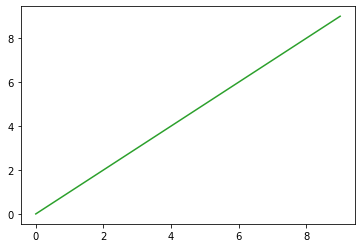

In [10]:
import numpy as np
plt.plot(np.arange(10), color='C2')

In [11]:
wcss['SUPA01564800.fits'].calc_footprint(),wcss['SUPA01564801.fits'].calc_footprint()

(array([[270.71086389, -24.38439851],
        [270.71122902, -24.14469939],
        [270.57159075, -24.14446074],
        [270.57096081, -24.38415718]]),
 array([[270.84011157, -24.3844512 ],
        [270.84023203, -24.14475087],
        [270.70059166, -24.14462957],
        [270.70020636, -24.38432854]]))

In [15]:
from ccdproc import ImageFileCollection
cols = ['MJD', 'OBJECT', 'DATA-TYP','CRPIX1', 'CRPIX2', 'CRVAL1', 'CRVAL2', 'EXP1TIME', 'GAIN']
im_collection = ImageFileCollection(subaru_fits_dir,keywords=cols)

In [16]:
im_collection.summary

file,MJD,OBJECT,DATA-TYP,CRPIX1,CRPIX2,CRVAL1,CRVAL2,EXP1TIME,GAIN
str17,float64,str4,str6,float64,float64,float64,float64,float64,float64
SUPA01564800.fits,57898.595399,M8,OBJECT,-3130.0,-37.0,270.90375,-24.38665278,120.0,3.32
SUPA01564801.fits,57898.595399,M8,OBJECT,-1032.0,-38.0,270.90375,-24.38665278,120.0,3.3
SUPA01564802.fits,57898.595399,M8,OBJECT,1068.0,-40.0,270.90375,-24.38665278,120.0,2.96
SUPA01564803.fits,57898.595399,M8,OBJECT,-3153.0,4167.0,270.90375,-24.38665278,120.0,3.58
SUPA01564804.fits,57898.595399,M8,OBJECT,-1068.0,4189.0,270.90375,-24.38665278,120.0,3.1
SUPA01564805.fits,57898.595399,M8,OBJECT,1055.0,4214.0,270.90375,-24.38665278,120.0,3.15
SUPA01564806.fits,57898.595399,M8,OBJECT,5276.0,25.0,270.90375,-24.38665278,120.0,3.73
SUPA01564807.fits,57898.595399,M8,OBJECT,3184.0,-14.0,270.90375,-24.38665278,120.0,2.99
SUPA01564808.fits,57898.595399,M8,OBJECT,5252.0,4213.0,270.90375,-24.38665278,120.0,3.65


In [83]:
def remove_oscan(ccd):
    hdr = ccd.header

    #four channels
    nchan=4
    eff_regions = np.array([[[hdr[f'S_EFMN{i}{ax}'], hdr[f'S_EFMx{i}{ax}'] ]\
                             for i in range(1,nchan+1)] for ax in [1,2]])

    #effective columns are page 0 of the above array
    #effective rows are page 1 of the above array
    eff_cols = np.concatenate([np.arange(eff_regions[0,c,0],eff_regions[0,c,1]+1)for c in range(nchan)])
    eff_rows = np.concatenate([np.arange(eff_regions[1,c,0],eff_regions[1,c,1]+1)for c in range(nchan)])
    
    #unique-ify and subtract 1 for python indexing
    # relying on np.unique to return array in sorted order
    eff_rows = np.unique(eff_rows)-1
    eff_cols = np.unique(eff_cols)-1

    data = ccd.data
    no_oscan = np.array([data[row][eff_cols] for row in eff_rows])

    return no_oscan


In [77]:
from utils import obs_dirs
import warnings
from astropy.nddata import CCDData

dirs = obs_dirs('../data','M8')
f=os.path.join(dirs['no_bias'], 'SUPA01564808.fits')
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    ccd = CCDData.read(f)
    

In [86]:
remove_oscan(ccd).shape, ccd.data.shape

((4177, 2048), (4273, 2272))

In [63]:
rows = np.array([1,3,4])
cols = np.array([2,4])
xx = np.arange(36).reshape(6,-1)
xx

array([[ 0,  1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10, 11],
       [12, 13, 14, 15, 16, 17],
       [18, 19, 20, 21, 22, 23],
       [24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35]])

In [65]:
np.array([x[cols] for x in xx[rows]])

array([[ 8, 10],
       [20, 22],
       [26, 28]])